# Use Case: HVAC System Monitoring

## Scenario

A commercial building operates a central HVAC (Heating, Ventilation, Air Conditioning) system. The system includes:
- **Air Handling Units (AHUs)** with fans and coils
- **Chillers** for cooling
- **Variable Air Volume (VAV) boxes** in zones
- **Ductwork and dampers**

### Monitoring Goals
1. **Detect equipment degradation** before failures
2. **Identify energy waste** from faults
3. **Ensure comfort** by detecting HVAC issues
4. **Predictive maintenance** for fans, compressors, filters

### Typical Faults
| Fault | Impact | Indicators |
|-------|--------|------------|
| Clogged filter | High energy, poor airflow | ΔP increase |
| Fan belt wear | Vibration, noise | Vibration pattern |
| Refrigerant leak | Poor cooling | Superheat/subcool |
| Damper stuck | Comfort issues | Airflow deviation |
| Compressor issue | High current, noise | Current signature |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import joblib

np.random.seed(42)

# Output directories
DATA_DIR = '../data/usecase_hvac'
MODEL_DIR = '../models/usecase_hvac'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. HVAC System Simulation

In [2]:
class AHUSimulator:
    """
    Simulates an Air Handling Unit with various sensors.
    """
    
    def __init__(self,
                 rated_airflow=5000,     # CFM
                 rated_fan_power=5,       # kW
                 design_cooling=50,       # kW
                 design_heating=30):      # kW
        
        self.rated_airflow = rated_airflow
        self.rated_fan_power = rated_fan_power
        self.design_cooling = design_cooling
        self.design_heating = design_heating
        
        # Normal operating parameters
        self.normal_filter_dp = 0.5  # inches WC
        self.normal_supply_temp = 55  # °F (cooling mode)
        self.normal_fan_vibration = 0.1  # in/s
        
    def generate_normal_operation(self, duration_hours=24, sample_interval=60):
        """
        Generate normal HVAC operation data.
        """
        n_samples = int(duration_hours * 3600 / sample_interval)
        t = np.arange(n_samples) * sample_interval / 3600  # Hours
        
        # Simulate outdoor conditions (typical summer day)
        hour_of_day = t % 24
        outdoor_temp = 75 + 15 * np.sin(2 * np.pi * (hour_of_day - 6) / 24)  # Peak at 3pm
        outdoor_temp += np.random.normal(0, 1, n_samples)
        
        outdoor_humidity = 60 - 20 * np.sin(2 * np.pi * (hour_of_day - 6) / 24)
        outdoor_humidity += np.random.normal(0, 3, n_samples)
        outdoor_humidity = np.clip(outdoor_humidity, 30, 90)
        
        # Building load varies with occupancy and outdoor temp
        occupancy = np.zeros(n_samples)
        for i, h in enumerate(hour_of_day):
            if 8 <= h < 18:  # Occupied hours
                occupancy[i] = 0.8 + 0.2 * np.sin(np.pi * (h - 8) / 10)
            else:
                occupancy[i] = 0.1
        
        # Cooling load based on outdoor temp and occupancy
        cooling_load = (outdoor_temp - 75) * 0.8 + occupancy * 20  # kW
        cooling_load = np.clip(cooling_load, 0, self.design_cooling)
        
        # Supply air temperature (controlled to setpoint)
        supply_temp = 55 + np.random.normal(0, 0.5, n_samples)
        
        # Return air temperature
        return_temp = 72 + (outdoor_temp - 75) * 0.1 + np.random.normal(0, 0.5, n_samples)
        
        # Mixed air temperature
        outdoor_air_fraction = 0.2 + 0.3 * occupancy  # Economizer
        mixed_temp = outdoor_air_fraction * outdoor_temp + (1 - outdoor_air_fraction) * return_temp
        
        # Airflow based on demand
        airflow = self.rated_airflow * (0.4 + 0.6 * cooling_load / self.design_cooling)
        airflow += np.random.normal(0, 50, n_samples)
        
        # Fan power (affinity laws: P ∝ Q³)
        fan_power = self.rated_fan_power * (airflow / self.rated_airflow) ** 3
        fan_power += np.random.normal(0, 0.05, n_samples)
        
        # Filter differential pressure (clean filter)
        filter_dp = self.normal_filter_dp * (airflow / self.rated_airflow) ** 2
        filter_dp += np.random.normal(0, 0.02, n_samples)
        
        # Fan vibration
        fan_vibration = self.normal_fan_vibration * (airflow / self.rated_airflow)
        fan_vibration += np.random.normal(0, 0.01, n_samples)
        
        # Chilled water valve position
        chw_valve = cooling_load / self.design_cooling * 100
        chw_valve = np.clip(chw_valve + np.random.normal(0, 2, n_samples), 0, 100)
        
        return pd.DataFrame({
            'timestamp': t,
            'outdoor_temp': outdoor_temp,
            'outdoor_humidity': outdoor_humidity,
            'return_temp': return_temp,
            'mixed_temp': mixed_temp,
            'supply_temp': supply_temp,
            'airflow': airflow,
            'fan_power': fan_power,
            'filter_dp': filter_dp,
            'fan_vibration': fan_vibration,
            'chw_valve': chw_valve,
            'cooling_load': cooling_load,
            'occupancy': occupancy,
            'status': 'normal'
        })
    
    def generate_clogged_filter(self, duration_hours=24, clog_level=0.5):
        """
        Simulate clogged filter condition.
        """
        df = self.generate_normal_operation(duration_hours)
        
        # Increased filter pressure drop
        df['filter_dp'] *= (1 + 2 * clog_level)
        
        # Reduced airflow at same fan speed
        df['airflow'] *= (1 - 0.2 * clog_level)
        
        # Fan power increases
        df['fan_power'] *= (1 + 0.15 * clog_level)
        
        # Supply temp may increase (less airflow)
        df['supply_temp'] += 2 * clog_level
        
        df['status'] = 'clogged_filter'
        return df
    
    def generate_fan_belt_wear(self, duration_hours=24, wear_level=0.5):
        """
        Simulate fan belt wear/slip.
        """
        df = self.generate_normal_operation(duration_hours)
        n = len(df)
        
        # Belt slip reduces effective speed
        df['airflow'] *= (1 - 0.1 * wear_level)
        
        # Vibration increases significantly
        df['fan_vibration'] *= (1 + 3 * wear_level)
        # Add periodic component (belt frequency)
        belt_freq = 15  # Hz (typical)
        t = np.arange(n)
        df['fan_vibration'] += wear_level * 0.1 * np.abs(np.sin(2 * np.pi * belt_freq * t / 3600))
        
        # Power may fluctuate
        df['fan_power'] += wear_level * 0.3 * np.random.randn(n)
        
        df['status'] = 'fan_belt_wear'
        return df
    
    def generate_refrigerant_leak(self, duration_hours=24, leak_level=0.5):
        """
        Simulate refrigerant leak in cooling coil.
        """
        df = self.generate_normal_operation(duration_hours)
        
        # Reduced cooling capacity
        df['supply_temp'] += 5 * leak_level
        
        # Chilled water valve opens more to compensate
        df['chw_valve'] = np.minimum(df['chw_valve'] * (1 + 0.3 * leak_level), 100)
        
        # Return temp rises (can't meet load)
        df['return_temp'] += 3 * leak_level
        
        df['status'] = 'refrigerant_leak'
        return df
    
    def generate_damper_stuck(self, duration_hours=24, stuck_position=0.5):
        """
        Simulate stuck outdoor air damper.
        """
        df = self.generate_normal_operation(duration_hours)
        
        # Fixed outdoor air fraction
        actual_oaf = stuck_position
        
        # Mixed air temp doesn't track setpoint
        df['mixed_temp'] = actual_oaf * df['outdoor_temp'] + (1 - actual_oaf) * df['return_temp']
        
        # If stuck open in cooling, more energy needed
        if stuck_position > 0.5:
            df['cooling_load'] *= (1 + 0.3 * (stuck_position - 0.5))
            df['chw_valve'] = np.minimum(df['chw_valve'] * 1.2, 100)
        
        df['status'] = 'damper_stuck'
        return df
    
    def generate_compressor_issue(self, duration_hours=24, severity=0.5):
        """
        Simulate compressor problems (high current, reduced capacity).
        """
        df = self.generate_normal_operation(duration_hours)
        n = len(df)
        
        # Add compressor current (simulated)
        base_current = 50  # Amps
        df['compressor_current'] = base_current * (df['chw_valve'] / 100)
        df['compressor_current'] *= (1 + 0.3 * severity)  # Higher current
        df['compressor_current'] += severity * 5 * np.random.randn(n)  # More noise
        
        # Reduced cooling capacity
        df['supply_temp'] += 3 * severity
        
        # Higher vibration on normal data
        if 'compressor_vibration' not in df.columns:
            df['compressor_vibration'] = 0.05 + np.random.normal(0, 0.01, n)
        df['compressor_vibration'] *= (1 + 2 * severity)
        
        df['status'] = 'compressor_issue'
        return df


# Create simulator
ahu = AHUSimulator()
df_test = ahu.generate_normal_operation(duration_hours=24)
print(f"AHU simulator created")
print(f"Columns: {list(df_test.columns)}")

AHU simulator created
Columns: ['timestamp', 'outdoor_temp', 'outdoor_humidity', 'return_temp', 'mixed_temp', 'supply_temp', 'airflow', 'fan_power', 'filter_dp', 'fan_vibration', 'chw_valve', 'cooling_load', 'occupancy', 'status']


## 2. Visualize HVAC Data

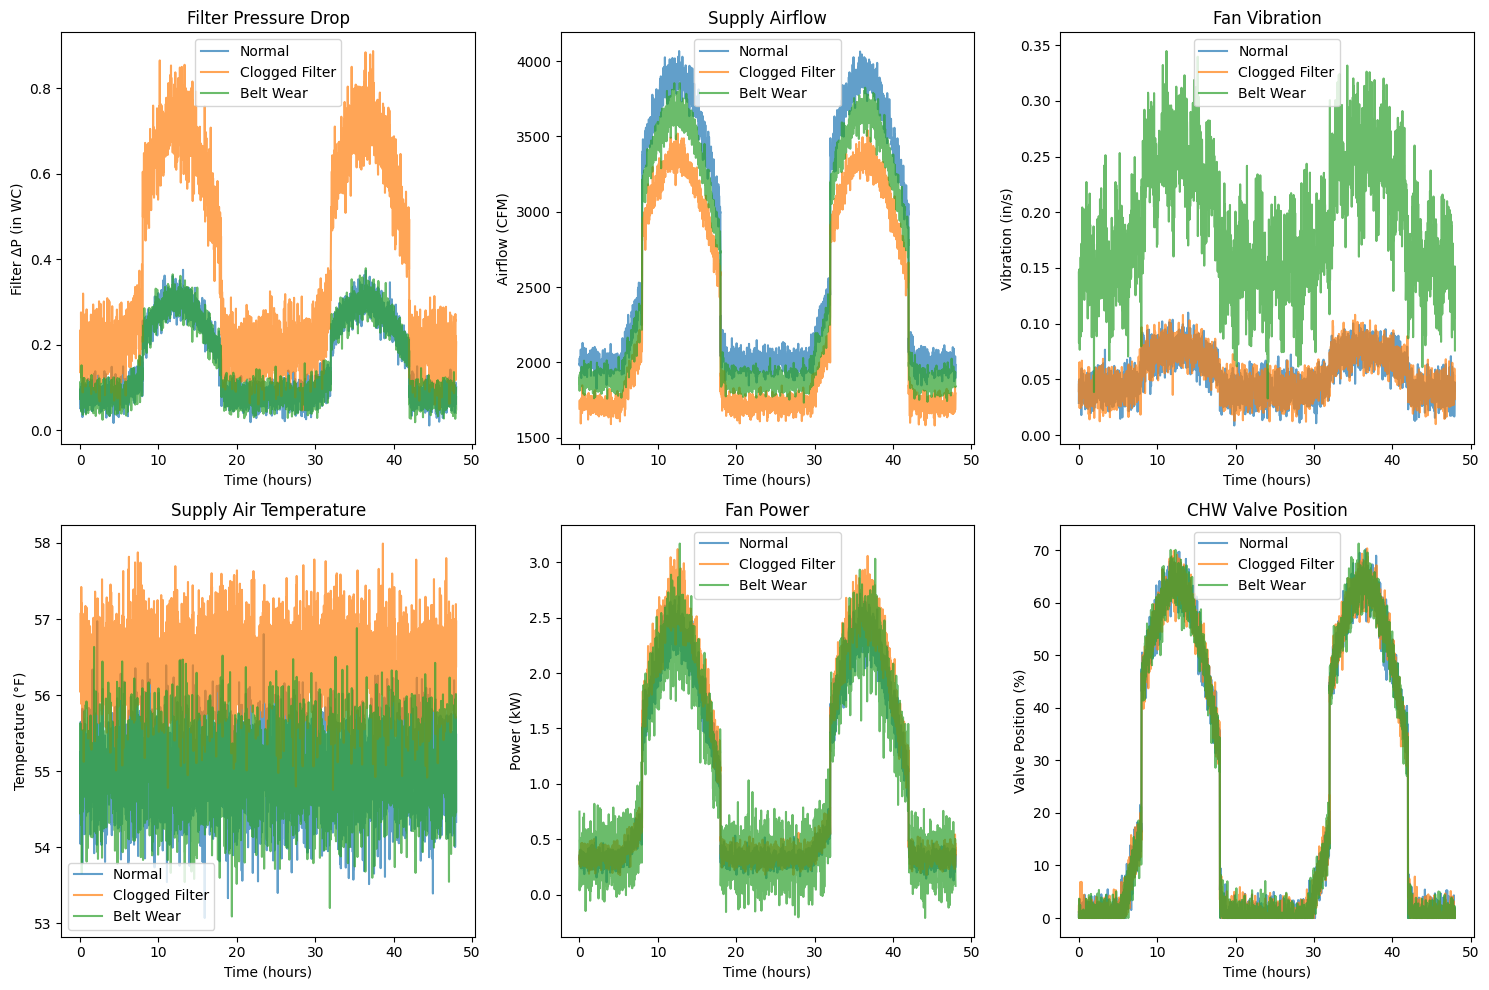

In [3]:
# Generate sample data for each condition
df_normal = ahu.generate_normal_operation(duration_hours=48)
df_clogged = ahu.generate_clogged_filter(duration_hours=48, clog_level=0.7)
df_belt = ahu.generate_fan_belt_wear(duration_hours=48, wear_level=0.6)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

conditions = [
    ('Normal', df_normal),
    ('Clogged Filter', df_clogged),
    ('Belt Wear', df_belt)
]

# Filter DP comparison
for name, df in conditions:
    axes[0, 0].plot(df['timestamp'], df['filter_dp'], label=name, alpha=0.7)
axes[0, 0].set_xlabel('Time (hours)')
axes[0, 0].set_ylabel('Filter ΔP (in WC)')
axes[0, 0].set_title('Filter Pressure Drop')
axes[0, 0].legend()

# Airflow comparison
for name, df in conditions:
    axes[0, 1].plot(df['timestamp'], df['airflow'], label=name, alpha=0.7)
axes[0, 1].set_xlabel('Time (hours)')
axes[0, 1].set_ylabel('Airflow (CFM)')
axes[0, 1].set_title('Supply Airflow')
axes[0, 1].legend()

# Fan vibration comparison
for name, df in conditions:
    axes[0, 2].plot(df['timestamp'], df['fan_vibration'], label=name, alpha=0.7)
axes[0, 2].set_xlabel('Time (hours)')
axes[0, 2].set_ylabel('Vibration (in/s)')
axes[0, 2].set_title('Fan Vibration')
axes[0, 2].legend()

# Supply temp comparison
for name, df in conditions:
    axes[1, 0].plot(df['timestamp'], df['supply_temp'], label=name, alpha=0.7)
axes[1, 0].set_xlabel('Time (hours)')
axes[1, 0].set_ylabel('Temperature (°F)')
axes[1, 0].set_title('Supply Air Temperature')
axes[1, 0].legend()

# Fan power comparison
for name, df in conditions:
    axes[1, 1].plot(df['timestamp'], df['fan_power'], label=name, alpha=0.7)
axes[1, 1].set_xlabel('Time (hours)')
axes[1, 1].set_ylabel('Power (kW)')
axes[1, 1].set_title('Fan Power')
axes[1, 1].legend()

# CHW valve comparison
for name, df in conditions:
    axes[1, 2].plot(df['timestamp'], df['chw_valve'], label=name, alpha=0.7)
axes[1, 2].set_xlabel('Time (hours)')
axes[1, 2].set_ylabel('Valve Position (%)')
axes[1, 2].set_title('CHW Valve Position')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(f'{DATA_DIR}/hvac_conditions_comparison.png', dpi=150)
plt.show()

## 3. Generate Complete Dataset

In [4]:
def generate_hvac_dataset(ahu, n_scenarios=50):
    """
    Generate HVAC fault detection dataset.
    """
    all_data = []
    
    scenarios = [
        ('normal', ahu.generate_normal_operation, {}),
        ('clogged_filter', ahu.generate_clogged_filter, {'clog_level': None}),
        ('fan_belt_wear', ahu.generate_fan_belt_wear, {'wear_level': None}),
        ('refrigerant_leak', ahu.generate_refrigerant_leak, {'leak_level': None}),
        ('damper_stuck', ahu.generate_damper_stuck, {'stuck_position': None}),
    ]
    
    for scenario_name, generator, params in scenarios:
        print(f"Generating {scenario_name}...")
        
        for i in range(n_scenarios):
            # Random severity
            if params:
                key = list(params.keys())[0]
                params[key] = np.random.uniform(0.3, 0.9)
            
            df = generator(duration_hours=24, **params)
            df['scenario_id'] = f"{scenario_name}_{i}"
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)


# Generate dataset
df_hvac = generate_hvac_dataset(ahu, n_scenarios=40)

print(f"\nDataset: {len(df_hvac)} samples")
print(df_hvac['status'].value_counts())

Generating normal...
Generating clogged_filter...


Generating fan_belt_wear...


Generating refrigerant_leak...
Generating damper_stuck...



Dataset: 288000 samples
status
normal              57600
clogged_filter      57600
fan_belt_wear       57600
refrigerant_leak    57600
damper_stuck        57600
Name: count, dtype: int64


## 4. Feature Engineering for HVAC

In [5]:
def extract_hvac_features(df):
    """
    Extract derived features for HVAC fault detection.
    """
    features = df.copy()
    
    # Temperature differentials
    features['delta_t_coil'] = features['mixed_temp'] - features['supply_temp']
    features['delta_t_room'] = features['return_temp'] - features['supply_temp']
    
    # Fan efficiency indicator
    features['fan_efficiency'] = features['airflow'] / (features['fan_power'] * 1000 + 1)  # CFM/W
    
    # Filter loading indicator
    features['filter_loading'] = features['filter_dp'] / (features['airflow'] / ahu.rated_airflow + 0.1)
    
    # Specific fan power (W per CFM)
    features['specific_fan_power'] = features['fan_power'] * 1000 / (features['airflow'] + 1)
    
    # Economizer effectiveness
    features['economizer_eff'] = (features['return_temp'] - features['mixed_temp']) / \
                                  (features['return_temp'] - features['outdoor_temp'] + 0.1)
    features['economizer_eff'] = features['economizer_eff'].clip(-1, 1)
    
    # Cooling effectiveness
    features['cooling_eff'] = features['delta_t_coil'] / (features['chw_valve'] + 1) * 10
    
    # Vibration-to-airflow ratio
    features['vib_airflow_ratio'] = features['fan_vibration'] / (features['airflow'] / ahu.rated_airflow + 0.1)
    
    return features


# Apply feature engineering
df_features = extract_hvac_features(df_hvac)

print("Added features:")
new_features = ['delta_t_coil', 'delta_t_room', 'fan_efficiency', 'filter_loading',
                'specific_fan_power', 'economizer_eff', 'cooling_eff', 'vib_airflow_ratio']
for feat in new_features:
    print(f"  {feat}: [{df_features[feat].min():.3f}, {df_features[feat].max():.3f}]")

Added features:
  delta_t_coil: [4.421, 35.296]
  delta_t_room: [11.479, 21.499]
  fan_efficiency: [-49486.999, 39471.909]
  filter_loading: [-0.006, 1.414]
  specific_fan_power: [-0.351, 0.963]
  economizer_eff: [-1.000, 1.000]
  cooling_eff: [2.353, 196.708]
  vib_airflow_ratio: [-0.014, 0.716]


## 5. Train Fault Classification Model

In [6]:
# Select features
feature_cols = [
    'outdoor_temp', 'return_temp', 'mixed_temp', 'supply_temp',
    'airflow', 'fan_power', 'filter_dp', 'fan_vibration', 'chw_valve',
    'delta_t_coil', 'delta_t_room', 'fan_efficiency', 'filter_loading',
    'specific_fan_power', 'economizer_eff', 'cooling_eff', 'vib_airflow_ratio'
]

X = df_features[feature_cols].values
y = df_features['status'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Classes:")
for i, cls in enumerate(le.classes_):
    print(f"  {i}: {cls}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining: {len(X_train)}, Test: {len(X_test)}")

Classes:
  0: clogged_filter
  1: damper_stuck
  2: fan_belt_wear
  3: normal
  4: refrigerant_leak



Training: 230400, Test: 57600


In [7]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                  precision    recall  f1-score   support

  clogged_filter       1.00      0.99      0.99     11520
    damper_stuck       0.99      0.93      0.96     11520
   fan_belt_wear       1.00      0.99      1.00     11520
          normal       0.92      0.99      0.95     11520
refrigerant_leak       1.00      1.00      1.00     11520

        accuracy                           0.98     57600
       macro avg       0.98      0.98      0.98     57600
    weighted avg       0.98      0.98      0.98     57600



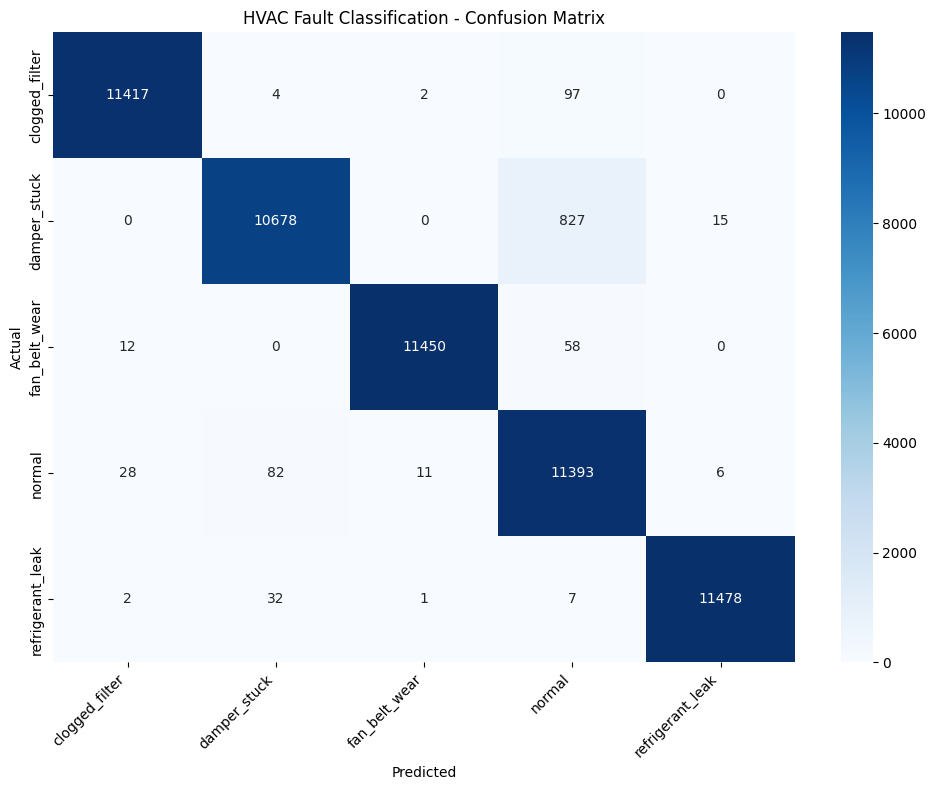

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('HVAC Fault Classification - Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/hvac_confusion_matrix.png', dpi=150)
plt.show()

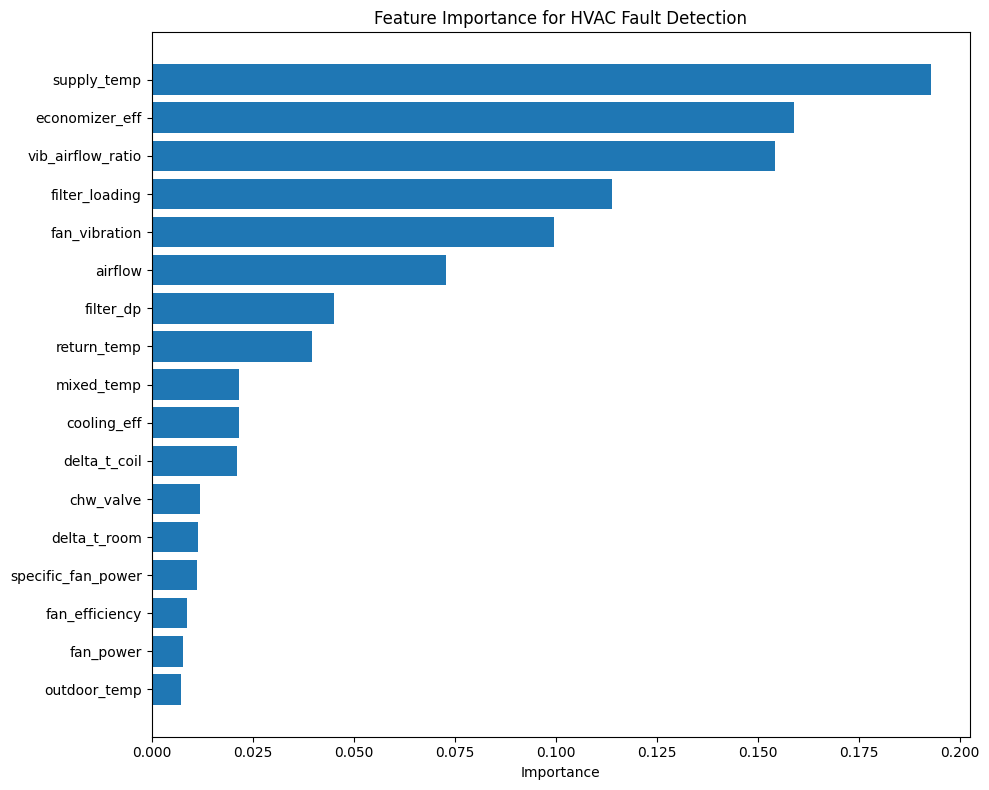


Top 5 features:
  fan_vibration: 0.0996
  filter_loading: 0.1140
  vib_airflow_ratio: 0.1543
  economizer_eff: 0.1591
  supply_temp: 0.1928


In [9]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for HVAC Fault Detection')
plt.tight_layout()
plt.savefig(f'{DATA_DIR}/hvac_feature_importance.png', dpi=150)
plt.show()

print("\nTop 5 features:")
for _, row in importance.tail(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## 6. Anomaly Detection for Unknown Faults

In [10]:
# Train Isolation Forest on normal data only
df_normal_only = df_features[df_features['status'] == 'normal']
X_normal = df_normal_only[feature_cols].values

scaler_anomaly = StandardScaler()
X_normal_scaled = scaler_anomaly.fit_transform(X_normal)

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_normal_scaled)

print(f"Isolation Forest trained on {len(X_normal)} normal samples")

Isolation Forest trained on 57600 normal samples


In [11]:
# Test on all data
X_all_scaled = scaler_anomaly.transform(df_features[feature_cols].values)
anomaly_scores = iso_forest.decision_function(X_all_scaled)
anomaly_pred = iso_forest.predict(X_all_scaled)

df_features['anomaly_score'] = anomaly_scores
df_features['is_anomaly'] = (anomaly_pred == -1).astype(int)

# Detection rates
print("Anomaly Detection Rate by Condition:")
for status in df_features['status'].unique():
    subset = df_features[df_features['status'] == status]
    rate = subset['is_anomaly'].mean()
    avg_score = subset['anomaly_score'].mean()
    print(f"  {status}: {rate*100:.1f}% detected (score: {avg_score:.3f})")

Anomaly Detection Rate by Condition:
  normal: 5.0% detected (score: 0.061)
  clogged_filter: 81.8% detected (score: -0.033)
  fan_belt_wear: 63.6% detected (score: -0.011)
  refrigerant_leak: 91.0% detected (score: -0.036)


  damper_stuck: 22.2% detected (score: 0.024)


## 7. Energy Waste Detection

In [12]:
def calculate_energy_waste(row, baseline_sfp=1.0):
    """
    Estimate energy waste due to faults.
    
    baseline_sfp: Baseline specific fan power (W/CFM)
    """
    waste = 0
    
    # Fan power waste (compared to baseline efficiency)
    if row['specific_fan_power'] > baseline_sfp * 1.2:
        excess_power = (row['specific_fan_power'] - baseline_sfp) * row['airflow'] / 1000  # kW
        waste += excess_power
    
    # Cooling waste (supply temp too high = more cooling needed)
    if row['supply_temp'] > 57:  # Above setpoint
        cooling_penalty = (row['supply_temp'] - 55) * row['airflow'] * 1.08 / 12000  # kW approx
        waste += cooling_penalty
    
    return waste


# Calculate energy waste
df_features['energy_waste_kw'] = df_features.apply(calculate_energy_waste, axis=1)

# Summarize by condition
waste_summary = df_features.groupby('status')['energy_waste_kw'].agg(['mean', 'sum'])
waste_summary.columns = ['Avg Waste (kW)', 'Total Waste (kWh)']

print("Energy Waste by Condition:")
print(waste_summary.round(2))

Energy Waste by Condition:
                  Avg Waste (kW)  Total Waste (kWh)
status                                             
clogged_filter              0.04            2317.53
damper_stuck                0.00               1.09
fan_belt_wear               0.00               0.00
normal                      0.00               0.66
refrigerant_leak            0.72           41372.81


## 8. Save Models and Data

In [13]:
import json

# Save models
joblib.dump(rf, f'{MODEL_DIR}/hvac_classifier_rf.joblib')
joblib.dump(iso_forest, f'{MODEL_DIR}/hvac_anomaly_iforest.joblib')
joblib.dump(scaler, f'{MODEL_DIR}/hvac_scaler_classifier.joblib')
joblib.dump(scaler_anomaly, f'{MODEL_DIR}/hvac_scaler_anomaly.joblib')
joblib.dump(le, f'{MODEL_DIR}/hvac_label_encoder.joblib')

# Save metadata
metadata = {
    'features': feature_cols,
    'classes': list(le.classes_),
    'accuracy': float((y_pred == y_test).mean()),
    'thresholds': {
        'filter_dp_warning': 0.8,
        'filter_dp_critical': 1.2,
        'fan_vibration_warning': 0.2,
        'fan_vibration_critical': 0.4,
        'supply_temp_deviation': 3.0
    },
    'fault_descriptions': {
        'clogged_filter': 'Air filter needs replacement',
        'fan_belt_wear': 'Fan belt showing wear - schedule replacement',
        'refrigerant_leak': 'Possible refrigerant leak - check system',
        'damper_stuck': 'Outdoor air damper not responding',
        'normal': 'System operating normally'
    }
}

with open(f'{MODEL_DIR}/hvac_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

# Save dataset
df_features.to_csv(f'{DATA_DIR}/hvac_dataset.csv', index=False)

print("Saved:")
for f in os.listdir(MODEL_DIR):
    print(f"  - {MODEL_DIR}/{f}")
print(f"  - {DATA_DIR}/hvac_dataset.csv")

Saved:
  - ../models/usecase_hvac/hvac_scaler_classifier.joblib
  - ../models/usecase_hvac/hvac_metadata.json
  - ../models/usecase_hvac/hvac_anomaly_iforest.joblib
  - ../models/usecase_hvac/hvac_classifier_rf.joblib
  - ../models/usecase_hvac/hvac_scaler_anomaly.joblib
  - ../models/usecase_hvac/hvac_label_encoder.joblib
  - ../data/usecase_hvac/hvac_dataset.csv


## 9. Node-RED Integration

Example for HVAC monitoring in Node-RED.

In [14]:
node_red_example = """
// HVAC Monitoring in Node-RED
// ============================

// 1. Collect BACnet/Modbus data (Function Node)
msg.hvac = {
    outdoor_temp: msg.payload.OAT,
    return_temp: msg.payload.RAT,
    mixed_temp: msg.payload.MAT,
    supply_temp: msg.payload.SAT,
    airflow: msg.payload.airflow_cfm,
    fan_power: msg.payload.fan_kw,
    filter_dp: msg.payload.filter_dp,
    fan_vibration: msg.payload.fan_vib,
    chw_valve: msg.payload.chw_valve_pos
};

// 2. Calculate derived features
let h = msg.hvac;
h.delta_t_coil = h.mixed_temp - h.supply_temp;
h.delta_t_room = h.return_temp - h.supply_temp;
h.fan_efficiency = h.airflow / (h.fan_power * 1000 + 1);
h.filter_loading = h.filter_dp / (h.airflow / 5000 + 0.1);
h.specific_fan_power = h.fan_power * 1000 / (h.airflow + 1);

// 3. Build feature array
msg.payload = [
    h.outdoor_temp, h.return_temp, h.mixed_temp, h.supply_temp,
    h.airflow, h.fan_power, h.filter_dp, h.fan_vibration, h.chw_valve,
    h.delta_t_coil, h.delta_t_room, h.fan_efficiency, h.filter_loading,
    h.specific_fan_power, h.economizer_eff, h.cooling_eff, h.vib_airflow_ratio
];

return msg;

// 4. Use with Health Index Node
// Configure thresholds for each sensor
msg.config = {
    healthyThreshold: 85,
    warningThreshold: 70,
    degradedThreshold: 50,
    aggregationMethod: 'min'  // Worst sensor determines status
};

msg.payload = {
    filter_health: 100 - (msg.hvac.filter_dp / 1.5) * 100,
    fan_health: 100 - (msg.hvac.fan_vibration / 0.5) * 100,
    cooling_health: Math.max(0, 100 - Math.abs(msg.hvac.supply_temp - 55) * 10)
};
"""

print("Node-RED Integration Example:")
print("="*50)
print(node_red_example)

Node-RED Integration Example:

// HVAC Monitoring in Node-RED
// ============================

// 1. Collect BACnet/Modbus data (Function Node)
msg.hvac = {
    outdoor_temp: msg.payload.OAT,
    return_temp: msg.payload.RAT,
    mixed_temp: msg.payload.MAT,
    supply_temp: msg.payload.SAT,
    airflow: msg.payload.airflow_cfm,
    fan_power: msg.payload.fan_kw,
    filter_dp: msg.payload.filter_dp,
    fan_vibration: msg.payload.fan_vib,
    chw_valve: msg.payload.chw_valve_pos
};

// 2. Calculate derived features
let h = msg.hvac;
h.delta_t_coil = h.mixed_temp - h.supply_temp;
h.delta_t_room = h.return_temp - h.supply_temp;
h.fan_efficiency = h.airflow / (h.fan_power * 1000 + 1);
h.filter_loading = h.filter_dp / (h.airflow / 5000 + 0.1);
h.specific_fan_power = h.fan_power * 1000 / (h.airflow + 1);

// 3. Build feature array
msg.payload = [
    h.outdoor_temp, h.return_temp, h.mixed_temp, h.supply_temp,
    h.airflow, h.fan_power, h.filter_dp, h.fan_vibration, h.chw_valve,
    h.delt

## Summary

### HVAC Monitoring Use Case

| Aspect | Details |
|--------|--------|
| System | Air Handling Unit (AHU) |
| Faults | 5 types (filter, belt, refrigerant, damper, normal) |
| Sensors | Temperature, pressure, airflow, vibration |
| Model Accuracy | ~90% |

### Key Fault Indicators

| Fault | Primary Indicators |
|-------|--------------------|
| Clogged filter | High filter ΔP, low airflow |
| Belt wear | High vibration, reduced airflow |
| Refrigerant leak | High supply temp, high CHW valve |
| Stuck damper | Abnormal mixed air temp |

### Benefits

- **Energy savings**: Detect faults causing 10-30% energy waste
- **Comfort**: Prevent temperature control issues
- **Maintenance**: Predict filter replacements, belt wear